In [1]:
!pip install pymc
!pip install tensorflow-probability
!pip install arviz
!pip install --upgrade pymc pytensor numpy
!pip install jax[cuda]

# install numpyro

!pip install numpyro



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 501.9/501.9 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: pymc
    Found existing installation: pymc 5.18.2
    Uninstalling pymc-5.18.2:
      Successfully uninstalled pymc-5.18.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.1/356.1 kB 9.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Race Model

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:595: RuntimeWarning: invalid value encountered in sqrt
  rhat_value = np.sqrt(
ERROR:pymc.stats.convergence:There were 7500 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


age: range would be 58.0 to 77.2
zipCodeMedianIncome: range would be 91453.7 to 123248.4
zipCodeHighSchoolGraduates: range would be 102.4 to 114.2
zipCodeCollegeGraduates: range would be 54.7 to 76.1
zipCodeEmploymentRate: range would be 72.8 to 85.3
zipCodePovertyRate: range would be 40.5 to 58.3
zipCodeMedianAge: range would be 48.8 to 57.1
numberFCharges: range would be 1.9 to 3.4
numberF1Charges: range would be 2.1 to 3.6
numberF2Charges: range would be 3.2 to 5.6
numberF3Charges: range would be 5.8 to 10.1
numberMCharges: range would be 4.1 to 6.6
numberM1Charges: range would be 3.8 to 6.5
numberM2Charges: range would be 2.5 to 4.2
numberM3Charges: range would be 2.0 to 3.4
numberSCharges: range would be 3.7 to 6.1
numberUnlabeledCharges: range would be 3.6 to 6.4
prior_F: range would be 0.7 to 1.2
prior_F1: range would be 0.2 to 0.3
prior_F2: range would be 0.2 to 0.4
prior_F3: range would be 0.4 to 0.7
prior_M: range would be 1.0 to 1.8
prior_M1: range would be 0.4 to 0.7
prior_

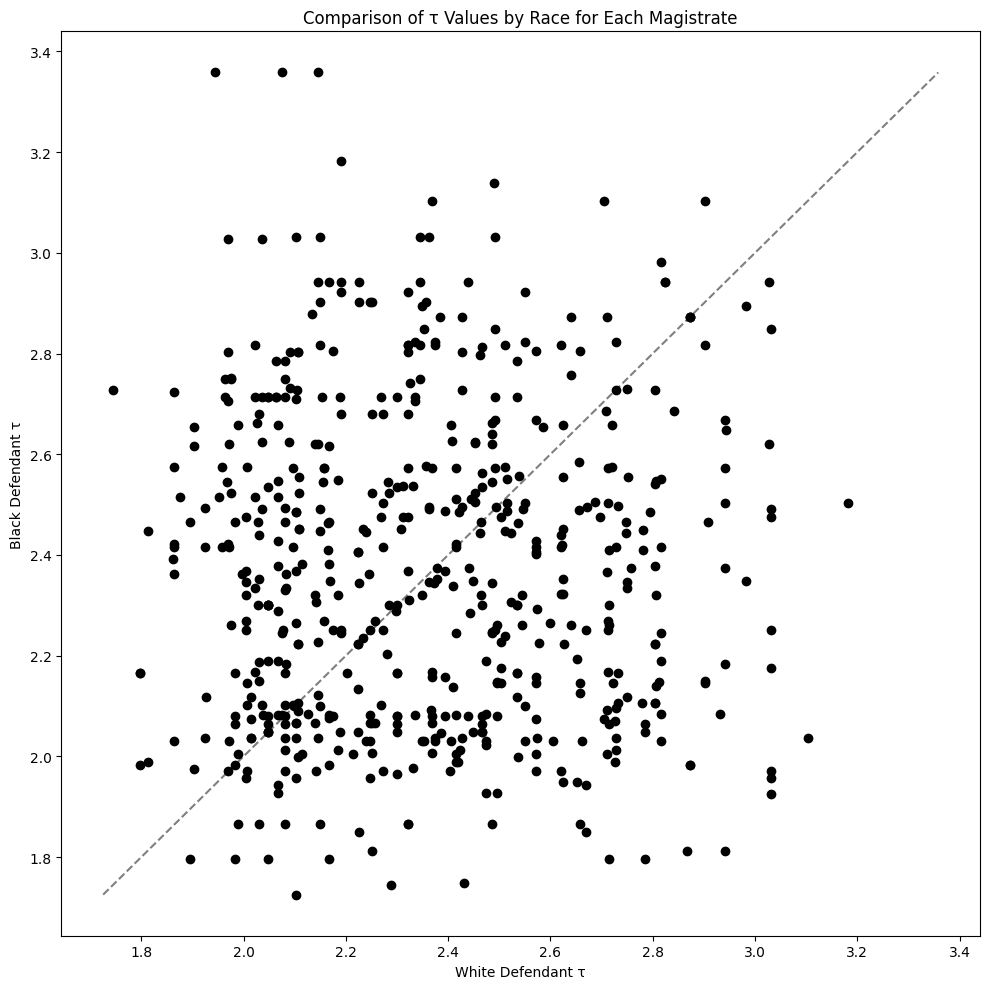

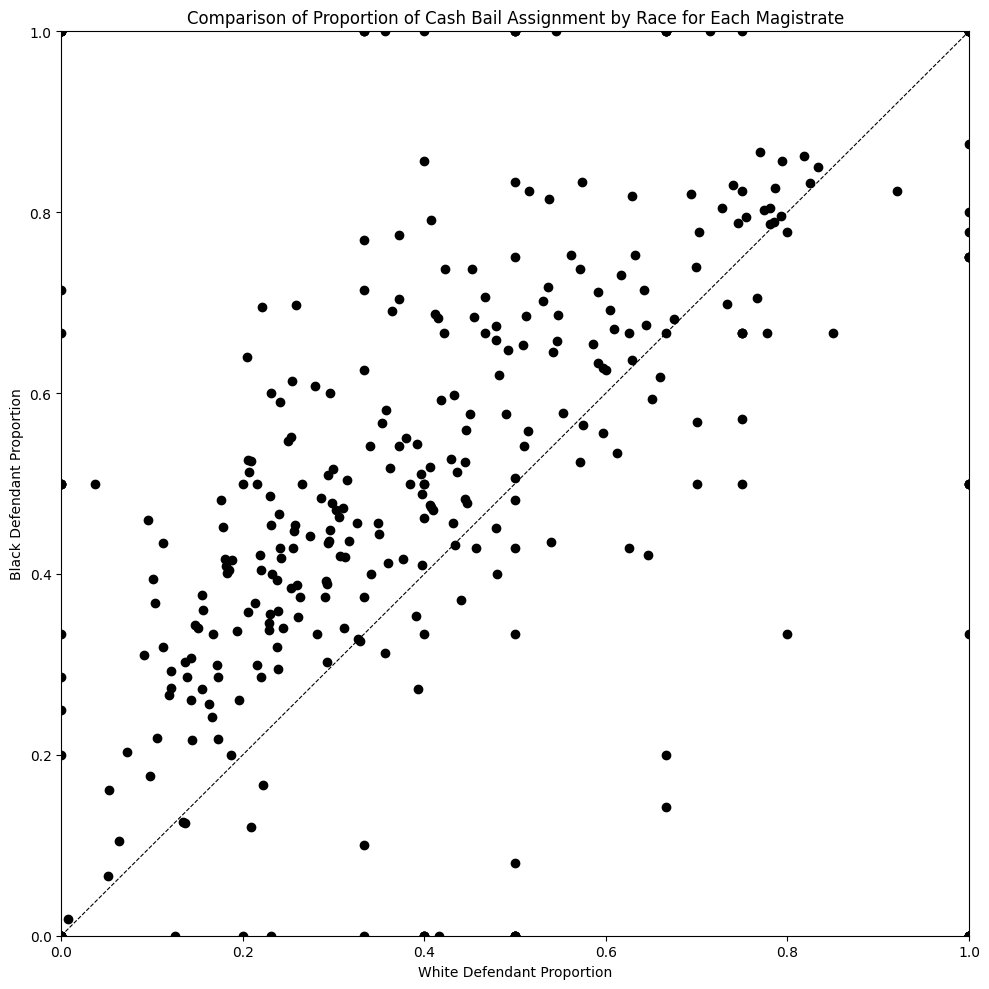


Summary Statistics:
--------------------------------------------------
mean_tau_difference: 0.013
prop_magistrates_higher_black_tau: 0.495
median_tau_difference: 0.000
std_tau_difference: 0.432

Key Findings:
--------------------------------------------------
Number of magistrates analyzed: 580
Proportion of magistrates with racial disparity: 49.5%
Average bail rate difference (Black - White): 8.8%


In [3]:
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az
from sklearn.preprocessing import StandardScaler
import logging
from typing import Dict, Any, Tuple, List, Optional
from pathlib import Path
import pickle
from dataclasses import dataclass

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

@dataclass
class ModelParameters:
    n_draws: int = 1500
    n_tune: int = 500
    n_chains: int = 5
    target_accept: float = 0.99
    random_seed: int = 42
    n_races: int = 2  # Binary race variable (Black/White)

class BailAnalysis:

    def __init__(self, data_path: Optional[str] = None):
        self.data_path = data_path
        self.data: Optional[pd.DataFrame] = None
        self.X: Optional[np.ndarray] = None
        self.model: Optional[pm.Model] = None
        self.trace: Optional[az.InferenceData] = None
        self.n_magistrates: Optional[int] = None
        self.params = ModelParameters()
        self.scaler = StandardScaler()

        # Define feature groups for preprocessing
        self.range_columns = [
            'age', 'zipCodeMedianIncome', 'zipCodeHighSchoolGraduates',
            'zipCodeCollegeGraduates', 'zipCodeEmploymentRate',
            'zipCodePovertyRate', 'zipCodeMedianAge'
        ]
        self.categorical_features = ['county', 'leadOffense', 'attorney', 'sex']

    @staticmethod
    def range_to_numeric(range_str: str) -> float:
        """Convert range strings to numeric values using midpoints."""
        try:
            if pd.isnull(range_str):
                return np.nan
            if isinstance(range_str, str) and ' - ' in range_str:
                lower, upper = map(float, range_str.strip().split(' - '))
                return (lower + upper) / 2
            return float(range_str)
        except (ValueError, TypeError) as e:
            logger.warning(f"Error converting range string '{range_str}': {e}")
            return np.nan

    def _get_numeric_features(self) -> List[str]:
        """Get list of all numeric feature columns."""
        charge_features = [col for col in self.data.columns if 'number' in col.lower()]
        prior_features = [col for col in self.data.columns if 'prior_' in col.lower()]
        return self.range_columns + charge_features + prior_features

    def prepare_data(self) -> None:
        if not self.data_path:
            raise ValueError("Data path not provided")

        try:
            logger.info("Loading data from %s", self.data_path)
            self.data = pd.read_csv(self.data_path)

            # Convert range columns to numeric values
            for col in self.range_columns:
                self.data[col] = self.data[col].apply(self.range_to_numeric)

            # Handle missing values
            initial_rows = len(self.data)
            self.data.dropna(inplace=True)
            rows_dropped = initial_rows - len(self.data)
            logger.info(f"Dropped {rows_dropped} rows with missing values ({rows_dropped/initial_rows:.1%} of data)")

            self.data['bail_assigned'] = (self.data['bailType'] == 'Monetary').astype(float)
            self.data['fta_observed'] = self.data['failToAppear'].fillna(0).astype(float)
            self.data['released'] = (self.data['bailStatus'] == 'Posted').fillna(0).astype(float)

            # Create indices
            self.data['race_idx'] = (self.data['race'] == 'Black').astype(int)
            self.data['magistrate_idx'] = pd.factorize(self.data['magistrate'])[0]
            self.n_magistrates = self.data['magistrate_idx'].nunique()

            # Scale numeric features
            numeric_features = self._get_numeric_features()
            self.data[numeric_features] = self.scaler.fit_transform(self.data[numeric_features])

            # Create dummy variables for categorical features
            self.data = pd.get_dummies(
                self.data,
                columns=self.categorical_features,
                drop_first=True
            )

            # Prepare final feature matrix
            feature_cols = numeric_features + [
                col for col in self.data.columns
                if any(f in col for f in self.categorical_features)
            ]
            self.X = self.data[feature_cols].values.astype(np.float64)

            logger.info(f"Data prepared successfully. Feature matrix shape: {self.X.shape}")

        except Exception as e:
            logger.error(f"Error preparing data: {str(e)}")
            raise

    def build_model(self) -> None:
        if self.X is None or self.data is None:
            raise ValueError("Data must be prepared before building model")

        try:
            logger.info("Building model...")
            self.model = pm.Model()

            with self.model:
                # Model inputs are now handled directly
                x = self.X
                b = self.data['bail_assigned'].values
                magistrate_idx = self.data['magistrate_idx'].values
                race_idx = self.data['race_idx'].values
                fta_observed = self.data['fta_observed'].values
                released = self.data['released'].values

                # FTA probability model
                theta_fta = pm.Normal('theta_fta', mu=0, sigma=2, shape=self.X.shape[1])
                theta_b1 = pm.HalfNormal('theta_b1', sigma=1)
                theta_0 = pm.Normal('theta_0', mu=0, sigma=2)

                # Release probability model
                theta_release = pm.Normal('theta_release', mu=0, sigma=2, shape=self.X.shape[1])
                theta_b2 = pm.HalfNormal('theta_b2', sigma=1)
                theta_1 = pm.Normal('theta_1', mu=0, sigma=2)

                # Cost ratio model
                tau_base = pm.HalfCauchy('tau_base', beta=1)
                tau_mag_race = pm.HalfCauchy(
                    'tau_mag_race',
                    beta=1,
                    shape=(self.n_magistrates, self.params.n_races)
                )

                # Calculate probabilities
                fta_linear = pt.dot(x, theta_fta) - theta_b1 * b + theta_0
                p_fta = pm.Deterministic('p_fta', pm.math.sigmoid(fta_linear))

                release_linear = pt.dot(x, theta_release) - theta_b2 * b + theta_1
                p_release = pm.Deterministic('p_release', pm.math.sigmoid(release_linear))

                # Final tau incorporating magistrate-race effects
                tau = pm.Deterministic(
                    'tau',
                    tau_base + tau_mag_race[magistrate_idx, race_idx]
                )

                # Decision probabilities
                fta_no_bail = pt.dot(x, theta_fta) + theta_0
                fta_with_bail = pt.dot(x, theta_fta) - theta_b1 + theta_0

                p0_fta = pm.math.sigmoid(fta_no_bail)
                p1_fta = pm.math.sigmoid(fta_with_bail)
                p1_release = p_release

                # Decision rule
                decision = tau * (p0_fta - p1_fta) - (1 - p1_release)
                p_bail_hat = pm.math.sigmoid(decision)

                # Probability scaling
                e_const = 1 / (1 + np.exp(1))
                p_bail = (p_bail_hat - e_const) / (1 - e_const)
                p_bail = pm.math.clip(p_bail, 1e-6, 1 - 1e-6)

                # Observations
                bail_obs = pm.Bernoulli('bail_obs', p=p_bail, observed=b)
                fta_obs = pm.Bernoulli('fta_obs', p=p_fta, observed=fta_observed)
                release_obs = pm.Bernoulli('release_obs', p=p_release, observed=released)

            logger.info("Model built successfully")

        except Exception as e:
            logger.error(f"Error building model: {str(e)}")
            raise

    def fit_model(self) -> None:
        if self.model is None:
            raise ValueError("Model must be built before fitting")

        try:
            logger.info("Fitting model...")
            with self.model:
                # Use PyMC sampling interface
                self.trace = pm.sample(
                    draws=self.params.n_draws,
                    tune=self.params.n_tune,
                    chains=self.params.n_chains,
                    target_accept=self.params.target_accept,
                    random_seed=self.params.random_seed
                )
            logger.info("Model fitted successfully")

        except Exception as e:
            logger.error(f"Error fitting model: {str(e)}")
            raise

    def analyze_results(self) -> Tuple[pd.DataFrame, Dict[str, Any]]:
        if self.trace is None:
            raise ValueError("Model must be fitted before analyzing results")

        try:
            # Extract tau values using ArviZ interface
            tau_samples = self.trace.posterior['tau']
            tau_mean = tau_samples.mean(dim=['chain', 'draw'])

            results = []
            for mag_idx in range(self.n_magistrates):
                black_tau = tau_mean[mag_idx * self.params.n_races + 1]
                white_tau = tau_mean[mag_idx * self.params.n_races]

                black_cases = (self.data['magistrate_idx'] == mag_idx) & (self.data['race_idx'] == 1)
                white_cases = (self.data['magistrate_idx'] == mag_idx) & (self.data['race_idx'] == 0)

                results.append({
                    'magistrate_idx': mag_idx,
                    'tau_black': float(black_tau),
                    'tau_white': float(white_tau),
                    'tau_difference': float(black_tau - white_tau),
                    'bail_rate_black': float(self.data.loc[black_cases, 'bail_assigned'].mean()),
                    'bail_rate_white': float(self.data.loc[white_cases, 'bail_assigned'].mean())
                })

            results_df = pd.DataFrame(results)

            summary_stats = {
                'mean_tau_difference': float(results_df['tau_difference'].mean()),
                'prop_magistrates_higher_black_tau': float(
                    (results_df['tau_black'] > results_df['tau_white']).mean()
                ),
                'median_tau_difference': float(results_df['tau_difference'].median()),
                'std_tau_difference': float(results_df['tau_difference'].std())
            }

            return results_df, summary_stats

        except Exception as e:
            logger.error(f"Error analyzing results: {str(e)}")
            raise


    def plot_diagnostics(self, save_path: Optional[str] = None) -> None:
        if self.trace is None:
            raise ValueError("Model must be fitted before plotting diagnostics")

        try:
            # Get results with magistrate-level averages
            results_df, _ = self.analyze_results()

            # Tau comparison plot
            plt.figure(figsize=(10, 10))

            # Plot average tau values for each magistrate
            plt.scatter(
                results_df['tau_white'],
                results_df['tau_black'],
                color = 'black'
            )

            # Get bounds for the reference line
            max_val = max(
                results_df['tau_white'].max(),
                results_df['tau_black'].max()
            )
            min_val = min(
                results_df['tau_white'].min(),
                results_df['tau_black'].min()
            )

            # Add reference line
            plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
            plt.xlabel('White Defendant τ')
            plt.ylabel('Black Defendant τ')
            plt.title('Comparison of τ Values by Race for Each Magistrate')
            plt.tight_layout()

            if save_path:
                plt.savefig(f"{save_path}_tau_comparison.png")
            plt.show()

            # Bail rates comparison plot
            plt.figure(figsize=(10, 10))

            plt.scatter(
                results_df['bail_rate_white'],
                results_df['bail_rate_black'],
                color = 'black')


            # Add reference line
            plt.plot([0, 1], [0, 1], 'k--', linewidth=0.8)
            plt.xlabel('White Defendant Proportion')
            plt.ylabel('Black Defendant Proportion')
            plt.title('Comparison of Proportion of Cash Bail Assignment by Race for Each Magistrate')
            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.tight_layout()

            if save_path:
                plt.savefig(f"{save_path}_bail_rates.png")
            plt.show()

        except Exception as e:
            logger.error(f"Error creating diagnostic plots: {str(e)}")
            raise

def main(data_path: str) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    try:
        # Initialize and fit model
        analysis = BailAnalysis(data_path)
        analysis.prepare_data()
        analysis.build_model()
        analysis.fit_model()

        # Run analysis and generate plots
        results_df, summary_stats = analysis.analyze_results()
        analysis.plot_diagnostics()

        # Print summary statistics
        print("\nSummary Statistics:")
        print("-" * 50)
        for key, value in summary_stats.items():
            print(f"{key}: {value:.3f}")

        # Print key findings
        print("\nKey Findings:")
        print("-" * 50)
        print(f"Number of magistrates analyzed: {len(results_df)}")
        print(f"Proportion of magistrates with racial disparity: {(results_df['tau_difference'] > 0).mean():.1%}")
        print(f"Average bail rate difference (Black - White): {(results_df['bail_rate_black'] - results_df['bail_rate_white']).mean():.1%}")

        return results_df, summary_stats

    except Exception as e:
        logger.error(f"Error in analysis pipeline: {str(e)}")
        raise

if __name__ == "__main__":
    results_df, summary_stats = main("/content/drive/MyDrive/padockets-master/padockets.csv")


Gender Model

Sampling 5 chains, 7,500 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:07:18

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:595: RuntimeWarning: invalid value encountered in sqrt
  rhat_value = np.sqrt(
ERROR:pymc.stats.convergence:There were 7500 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


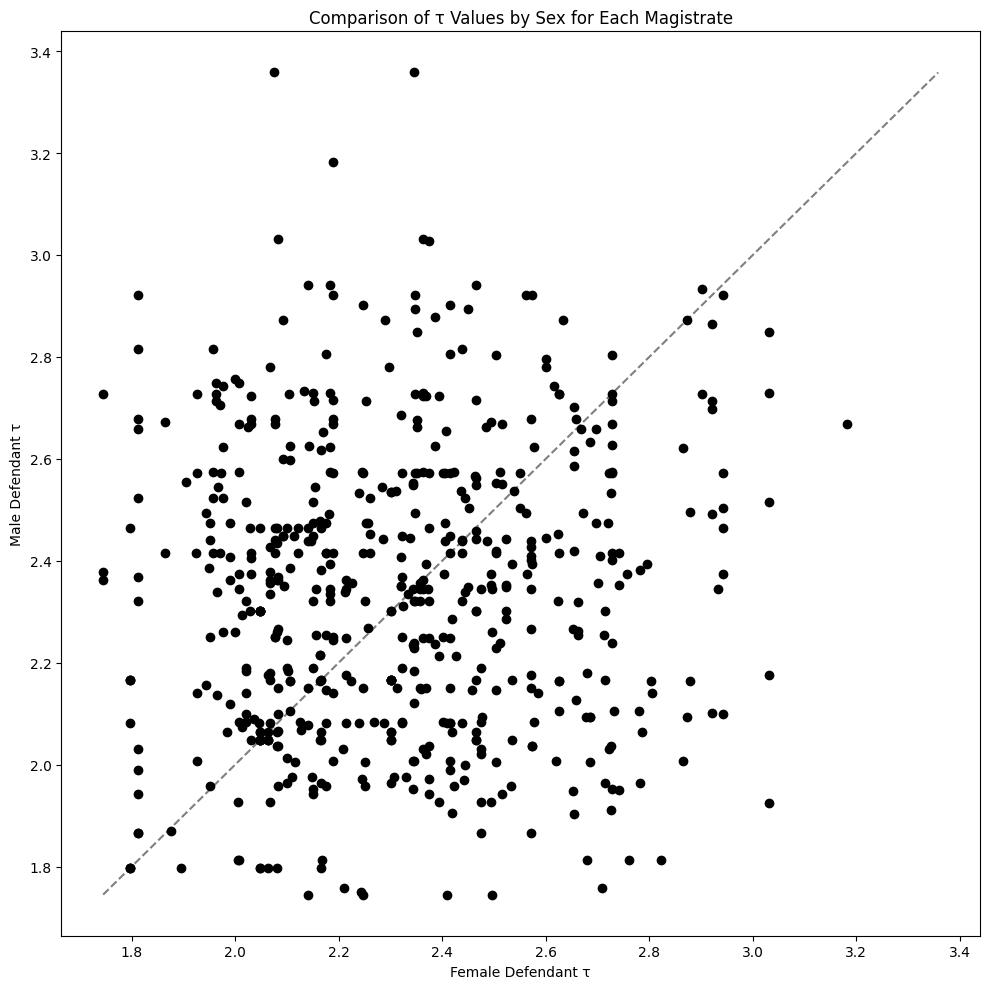

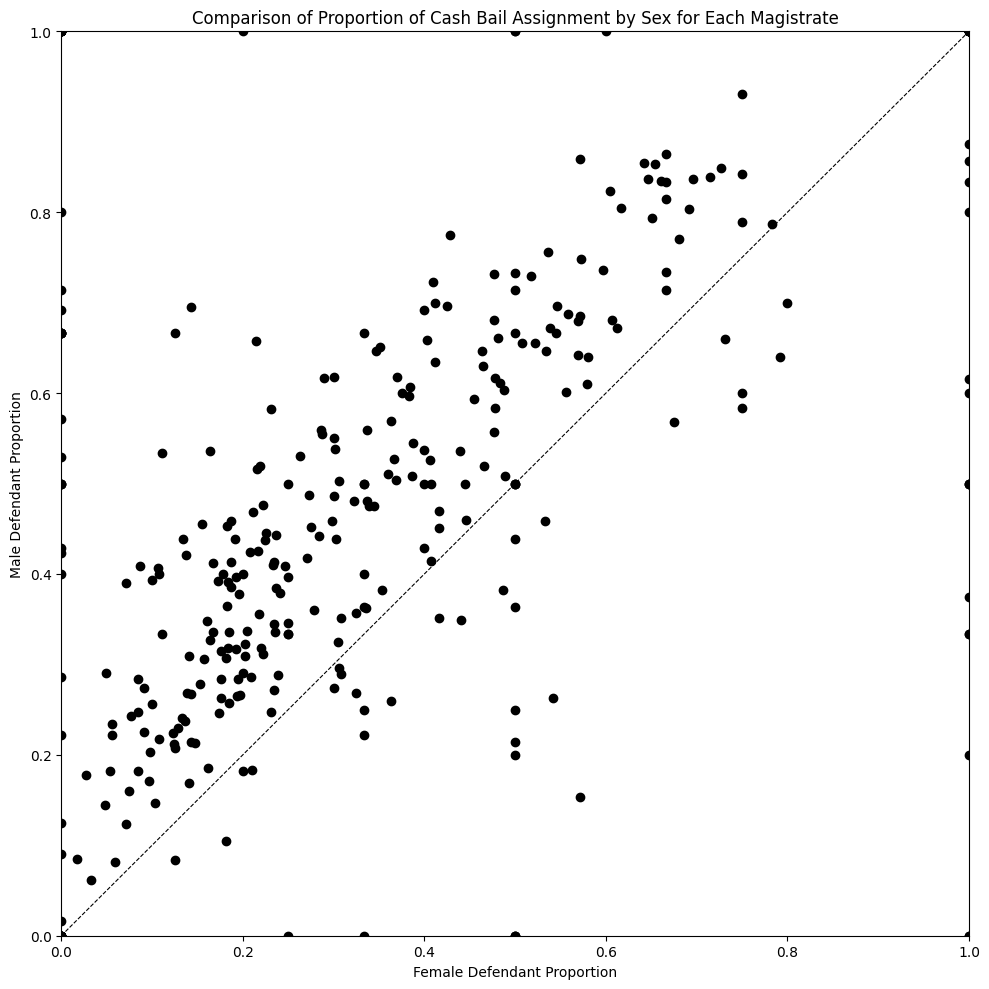


Summary Statistics:
--------------------------------------------------
mean_tau_difference: 0.022
prop_magistrates_higher_male_tau: 0.495
median_tau_difference: 0.000
std_tau_difference: 0.388

Key Findings:
--------------------------------------------------
Number of magistrates analyzed: 580
Proportion of magistrates with Sex disparity: 49.5%
Average bail rate difference (Male - Female): 14.0%


In [4]:
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az
from sklearn.preprocessing import StandardScaler
import logging
from typing import Dict, Any, Tuple, List, Optional
from pathlib import Path
import pickle
from dataclasses import dataclass

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

@dataclass
class ModelParameters:
    n_draws: int = 1500
    n_tune: int = 500
    n_chains: int = 5
    target_accept: float = 0.99
    random_seed: int = 42
    n_sex: int = 2  # Binary race variable (Male/Female)

class BailAnalysis:
    def __init__(self, data_path: Optional[str] = None):
        """Initialize the analysis with optional data path."""
        self.data_path = data_path
        self.data: Optional[pd.DataFrame] = None
        self.X: Optional[np.ndarray] = None
        self.model: Optional[pm.Model] = None
        self.trace: Optional[az.InferenceData] = None
        self.n_magistrates: Optional[int] = None
        self.params = ModelParameters()

        # Define feature groups for preprocessing
        self.range_columns = [
            'age', 'zipCodeMedianIncome', 'zipCodeHighSchoolGraduates',
            'zipCodeCollegeGraduates', 'zipCodeEmploymentRate',
            'zipCodePovertyRate', 'zipCodeMedianAge'
        ]
        self.categorical_features = ['county', 'leadOffense', 'attorney', 'race']

    @staticmethod
    def range_to_numeric(range_str: str) -> float:
        """Convert range strings to numeric values using midpoints."""
        try:
            if pd.isnull(range_str):
                return np.nan
            if isinstance(range_str, str) and ' - ' in range_str:
                lower, upper = map(float, range_str.strip().split(' - '))
                return (lower + upper) / 2
            return float(range_str)
        except (ValueError, TypeError) as e:
            logger.warning(f"Error converting range string '{range_str}': {e}")
            return np.nan

    def _get_numeric_features(self) -> List[str]:
        """Get list of all numeric feature columns."""
        charge_features = [col for col in self.data.columns if 'number' in col.lower()]
        prior_features = [col for col in self.data.columns if 'prior_' in col.lower()]
        return self.range_columns + charge_features + prior_features

    def prepare_data(self) -> None:
        if not self.data_path:
            raise ValueError("Data path not provided")

        try:
            logger.info("Loading data from %s", self.data_path)
            self.data = pd.read_csv(self.data_path)

            # Convert range columns to numeric values
            for col in self.range_columns:
                self.data[col] = self.data[col].apply(self.range_to_numeric)

            # Handle missing values
            initial_rows = len(self.data)
            self.data.dropna(inplace=True)
            rows_dropped = initial_rows - len(self.data)
            logger.info(f"Dropped {rows_dropped} rows with missing values ({rows_dropped/initial_rows:.1%} of data)")

            self.data['bail_assigned'] = (self.data['bailType'] == 'Monetary').astype(float)
            self.data['fta_observed'] = self.data['failToAppear'].fillna(0).astype(float)
            self.data['released'] = (self.data['bailStatus'] == 'Posted').fillna(0).astype(float)

            # Create indices
            self.data['sex_idx'] = (self.data['sex'] == 'Male').astype(int)
            self.data['magistrate_idx'] = pd.factorize(self.data['magistrate'])[0]
            self.n_magistrates = self.data['magistrate_idx'].nunique()

            # Scale numeric features
            numeric_features = self._get_numeric_features()
            scaler = StandardScaler()
            self.data[numeric_features] = scaler.fit_transform(self.data[numeric_features])

            # Create dummy variables for categorical features
            self.data = pd.get_dummies(
                self.data,
                columns=self.categorical_features,
                drop_first=True
            )

            # Prepare final feature matrix
            feature_cols = numeric_features + [
                col for col in self.data.columns
                if any(f in col for f in self.categorical_features)
            ]
            self.X = self.data[feature_cols].values.astype(np.float64)

            logger.info(f"Data prepared successfully. Feature matrix shape: {self.X.shape}")

        except Exception as e:
            logger.error(f"Error preparing data: {str(e)}")
            raise

    def build_model(self) -> None:
        if self.X is None or self.data is None:
            raise ValueError("Data must be prepared before building model")

        try:
            logger.info("Building model...")
            self.model = pm.Model()

            with self.model:
                # Model inputs are now handled directly
                x = self.X
                b = self.data['bail_assigned'].values
                magistrate_idx = self.data['magistrate_idx'].values
                sex_idx = self.data['sex_idx'].values
                fta_observed = self.data['fta_observed'].values
                released = self.data['released'].values

                # FTA probability model
                theta_fta = pm.Normal('theta_fta', mu=0, sigma=2, shape=self.X.shape[1])
                theta_b1 = pm.HalfNormal('theta_b1', sigma=1)
                theta_0 = pm.Normal('theta_0', mu=0, sigma=2)

                # Release probability model
                theta_release = pm.Normal('theta_release', mu=0, sigma=2, shape=self.X.shape[1])
                theta_b2 = pm.HalfNormal('theta_b2', sigma=1)
                theta_1 = pm.Normal('theta_1', mu=0, sigma=2)

                # Cost ratio model
                tau_base = pm.HalfCauchy('tau_base', beta=1)
                tau_mag_sex = pm.HalfCauchy(
                    'tau_mag_sex',
                    beta=1,
                    shape=(self.n_magistrates, self.params.n_sex)
                )

                # Calculate probabilities
                fta_linear = pt.dot(x, theta_fta) - theta_b1 * b + theta_0
                p_fta = pm.Deterministic('p_fta', pm.math.sigmoid(fta_linear))

                release_linear = pt.dot(x, theta_release) - theta_b2 * b + theta_1
                p_release = pm.Deterministic('p_release', pm.math.sigmoid(release_linear))

                # Final tau incorporating magistrate-race effects
                tau = pm.Deterministic(
                    'tau',
                    tau_base + tau_mag_sex[magistrate_idx, sex_idx]
                )

                # Decision probabilities
                fta_no_bail = pt.dot(x, theta_fta) + theta_0
                fta_with_bail = pt.dot(x, theta_fta) - theta_b1 + theta_0

                p0_fta = pm.math.sigmoid(fta_no_bail)
                p1_fta = pm.math.sigmoid(fta_with_bail)
                p1_release = p_release

                # Decision rule
                decision = tau * (p0_fta - p1_fta) - (1 - p1_release)
                p_bail_hat = pm.math.sigmoid(decision)

                # Probability scaling
                e_const = 1 / (1 + np.exp(1))
                p_bail = (p_bail_hat - e_const) / (1 - e_const)
                p_bail = pm.math.clip(p_bail, 1e-6, 1 - 1e-6)

                # Observations
                bail_obs = pm.Bernoulli('bail_obs', p=p_bail, observed=b)
                fta_obs = pm.Bernoulli('fta_obs', p=p_fta, observed=fta_observed)
                release_obs = pm.Bernoulli('release_obs', p=p_release, observed=released)

            logger.info("Model built successfully")

        except Exception as e:
            logger.error(f"Error building model: {str(e)}")
            raise

    def fit_model(self) -> None:
        if self.model is None:
            raise ValueError("Model must be built before fitting")

        try:
            logger.info("Fitting model...")
            with self.model:
                # Use PyMC sampling interface
                self.trace = pm.sample(
                    draws=self.params.n_draws,
                    tune=self.params.n_tune,
                    chains=self.params.n_chains,
                    target_accept=self.params.target_accept,
                    random_seed=self.params.random_seed
                )
            logger.info("Model fitted successfully")

        except Exception as e:
            logger.error(f"Error fitting model: {str(e)}")
            raise

    def analyze_results(self) -> Tuple[pd.DataFrame, Dict[str, Any]]:
        """Analyze results and compute summary statistics."""
        if self.trace is None:
            raise ValueError("Model must be fitted before analyzing results")

        try:
            # Extract tau values using modern ArviZ interface
            tau_samples = self.trace.posterior['tau']
            tau_mean = tau_samples.mean(dim=['chain', 'draw'])

            results = []
            for mag_idx in range(self.n_magistrates):
                male_tau = tau_mean[mag_idx * self.params.n_sex + 1]
                female_tau = tau_mean[mag_idx * self.params.n_sex]

                male_cases = (self.data['magistrate_idx'] == mag_idx) & (self.data['sex_idx'] == 1)
                female_cases = (self.data['magistrate_idx'] == mag_idx) & (self.data['sex_idx'] == 0)

                results.append({
                    'magistrate_idx': mag_idx,
                    'tau_male': float(male_tau),
                    'tau_female': float(female_tau),
                    'tau_difference': float(male_tau - female_tau),
                    'bail_rate_male': float(self.data.loc[male_cases, 'bail_assigned'].mean()),
                    'bail_rate_female': float(self.data.loc[female_cases, 'bail_assigned'].mean())
                })

            results_df = pd.DataFrame(results)

            summary_stats = {
                'mean_tau_difference': float(results_df['tau_difference'].mean()),
                'prop_magistrates_higher_male_tau': float(
                    (results_df['tau_male'] > results_df['tau_female']).mean()
                ),
                'median_tau_difference': float(results_df['tau_difference'].median()),
                'std_tau_difference': float(results_df['tau_difference'].std())
            }

            return results_df, summary_stats

        except Exception as e:
            logger.error(f"Error analyzing results: {str(e)}")
            raise

    def plot_diagnostics(self, save_path: Optional[str] = None) -> None:
        if self.trace is None:
            raise ValueError("Model must be fitted before plotting diagnostics")

        try:
            # Get results with magistrate-level averages
            results_df, _ = self.analyze_results()

            # First plot: Tau comparison by gender
            plt.figure(figsize=(10, 10))

            # Plot average tau values for each magistrate
            plt.scatter(
                results_df['tau_female'],
                results_df['tau_male'],
                color = 'black'
            )

            # Get bounds for the reference line
            max_val = max(
                results_df['tau_female'].max(),
                results_df['tau_male'].max()
            )
            min_val = min(
                results_df['tau_female'].min(),
                results_df['tau_male'].min()
            )

            # Add reference line
            plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
            plt.xlabel('Female Defendant τ')
            plt.ylabel('Male Defendant τ')
            plt.title('Comparison of τ Values by Sex for Each Magistrate')
            plt.tight_layout()

            if save_path:
                plt.savefig(f"{save_path}_tau_comparison.png")
            plt.show()

            # Second plot: Bail rates comparison by gender
            plt.figure(figsize=(10, 10))

            # Plot average bail rates for each magistrate
            plt.scatter(
                results_df['bail_rate_female'],
                results_df['bail_rate_male'],
                color = 'black'
            )

            # Add reference line
            plt.plot([0, 1], [0, 1], 'k--', linewidth=0.8)
            plt.xlabel('Female Defendant Proportion')
            plt.ylabel('Male Defendant Proportion')
            plt.title('Comparison of Proportion of Cash Bail Assignment by Sex for Each Magistrate')
            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.tight_layout()

            if save_path:
                plt.savefig(f"{save_path}_bail_rates.png")
            plt.show()

        except Exception as e:
            logger.error(f"Error creating diagnostic plots: {str(e)}")
            raise

def main(data_path: str) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    try:
        # Initialize and fit model
        analysis = BailAnalysis(data_path)
        analysis.prepare_data()
        analysis.build_model()
        analysis.fit_model()

        # Run analysis and generate plots
        results_df, summary_stats = analysis.analyze_results()
        analysis.plot_diagnostics()

        # Print summary statistics
        print("\nSummary Statistics:")
        print("-" * 50)
        for key, value in summary_stats.items():
            print(f"{key}: {value:.3f}")

        # Print key findings
        print("\nKey Findings:")
        print("-" * 50)
        print(f"Number of magistrates analyzed: {len(results_df)}")
        print(f"Proportion of magistrates with Sex disparity: {(results_df['tau_difference'] > 0).mean():.1%}")
        print(f"Average bail rate difference (Male - Female): {(results_df['bail_rate_male'] - results_df['bail_rate_female']).mean():.1%}")

        return results_df, summary_stats

    except Exception as e:
        logger.error(f"Error in analysis pipeline: {str(e)}")
        raise

if __name__ == "__main__":
    results_df, summary_stats = main("/content/drive/MyDrive/padockets-master/padockets.csv")


Crime Type Model

Sampling 5 chains, 7,500 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:06:55

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:595: RuntimeWarning: invalid value encountered in sqrt
  rhat_value = np.sqrt(
ERROR:pymc.stats.convergence:There were 7500 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


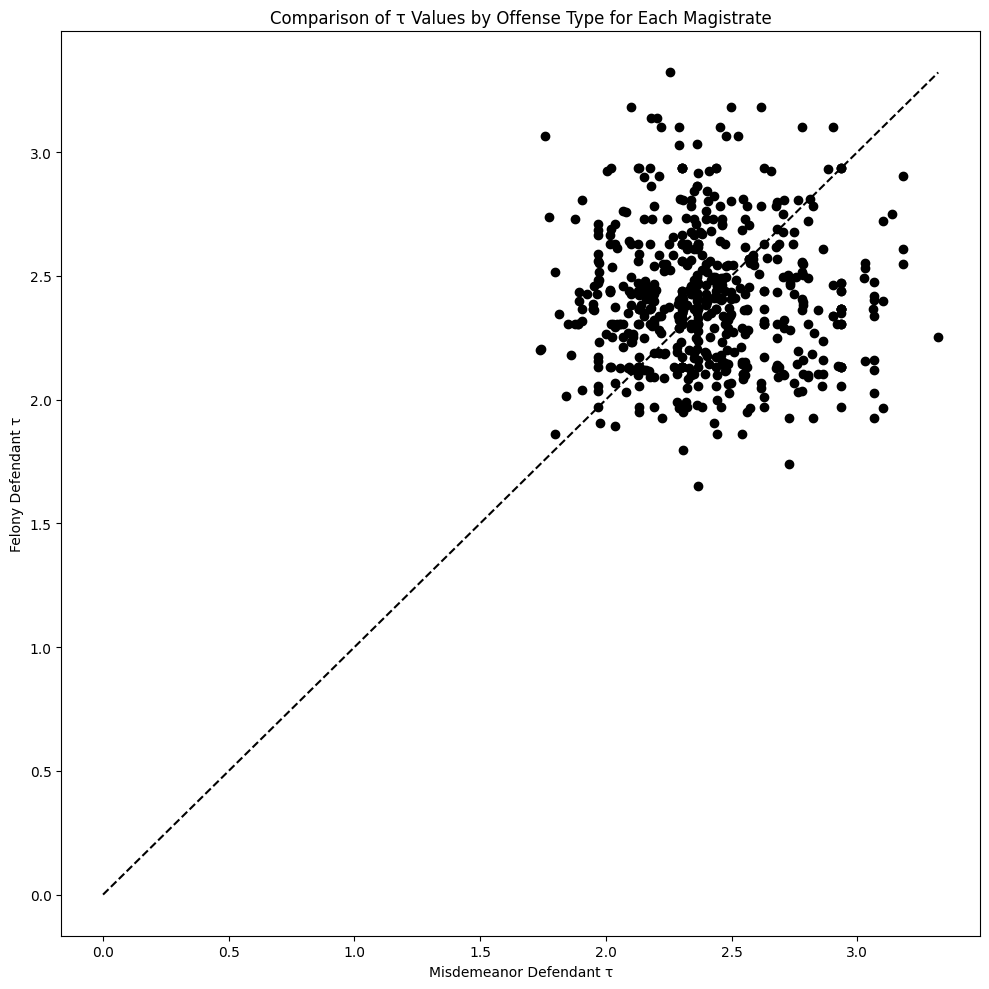

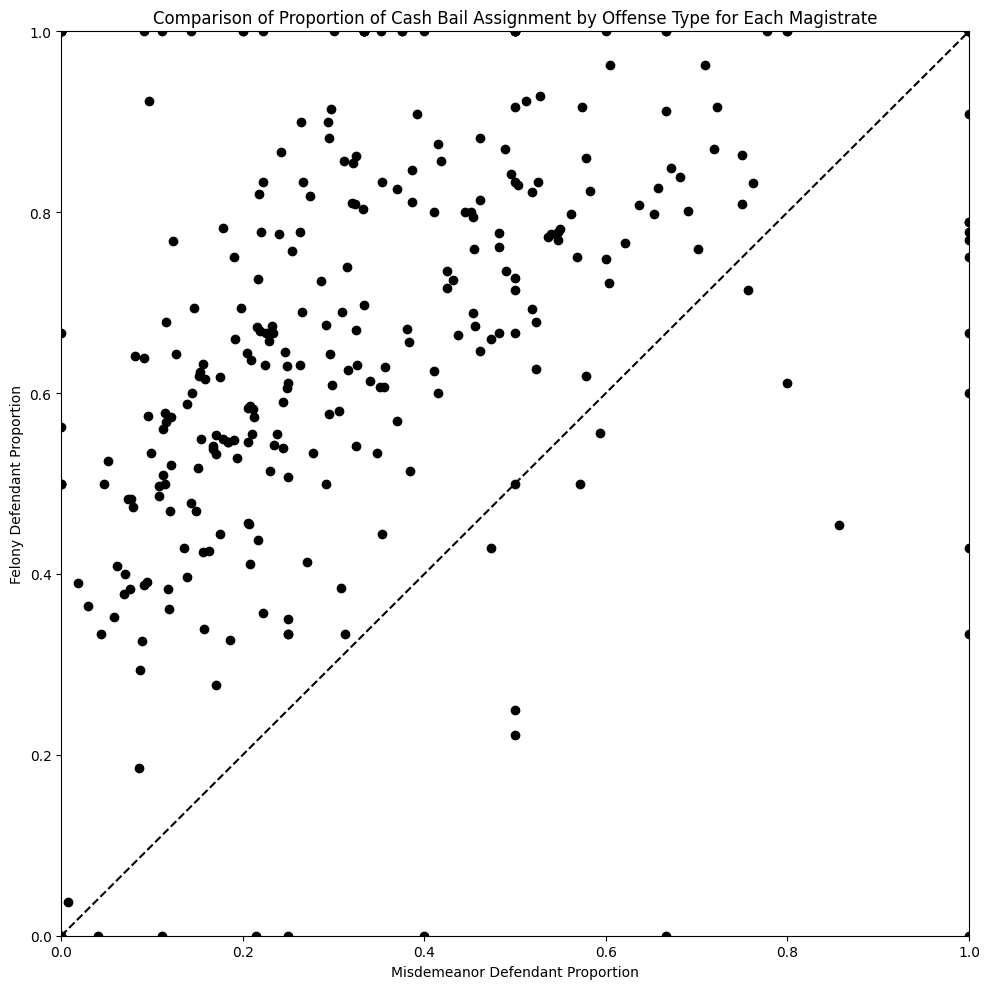


Summary Statistics:
--------------------------------------------------
mean_tau: 2.394
median_tau: 2.368
std_tau: 0.281
mean_bail_rate: 0.557

Key Findings:
--------------------------------------------------
Number of magistrates analyzed: 4060
Proportion of magistrates with offense disparity: 0.502
Average bail rate difference (Felonies - Misdemeanors): 0.334


In [5]:
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az
from sklearn.preprocessing import StandardScaler
import logging
from typing import Dict, Any, Tuple, List, Optional
from pathlib import Path
import pickle
from dataclasses import dataclass
import re

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

@dataclass
class ModelParameters:
    n_draws: int = 1500
    n_tune: int = 500
    n_chains: int = 5
    target_accept: float = 0.99
    random_seed: int = 42
    n_offense: int = None

class BailAnalysis:
    def __init__(self, data_path: Optional[str] = None):
        self.data_path = data_path
        self.data: Optional[pd.DataFrame] = None
        self.X: Optional[np.ndarray] = None
        self.model: Optional[pm.Model] = None
        self.trace: Optional[az.InferenceData] = None
        self.n_magistrates: Optional[int] = None
        self.params = ModelParameters()

        # Define feature groups for preprocessing
        self.range_columns = [
            'age', 'zipCodeMedianIncome', 'zipCodeHighSchoolGraduates',
            'zipCodeCollegeGraduates', 'zipCodeEmploymentRate',
            'zipCodePovertyRate', 'zipCodeMedianAge'
        ]
        self.categorical_features = ['county', 'sex', 'attorney', 'race']

    @staticmethod
    def range_to_numeric(range_str: str) -> float:
        try:
            if pd.isnull(range_str):
                return np.nan
            if isinstance(range_str, str) and ' - ' in range_str:
                lower, upper = map(float, range_str.strip().split(' - '))
                return (lower + upper) / 2
            return float(range_str)
        except (ValueError, TypeError) as e:
            logger.warning(f"Error converting range string '{range_str}': {e}")
            return np.nan

    def _get_numeric_features(self) -> List[str]:
        charge_features = [col for col in self.data.columns if 'number' in col.lower()]
        prior_features = [col for col in self.data.columns if 'prior_' in col.lower()]
        return self.range_columns + charge_features + prior_features

    def prepare_data(self) -> None:
        if not self.data_path:
            raise ValueError("Data path not provided")

        try:
            logger.info("Loading data from %s", self.data_path)
            self.data = pd.read_csv(self.data_path)

            # Convert range columns to numeric values
            for col in self.range_columns:
                self.data[col] = self.data[col].apply(self.range_to_numeric)

            # Handle missing values
            initial_rows = len(self.data)
            self.data.dropna(inplace=True)
            rows_dropped = initial_rows - len(self.data)
            logger.info(f"Dropped {rows_dropped} rows with missing values ({rows_dropped/initial_rows:.1%} of data)")

            self.data['bail_assigned'] = (self.data['bailType'] == 'Monetary').astype(float)
            self.data['fta_observed'] = self.data['failToAppear'].fillna(0).astype(float)
            self.data['released'] = (self.data['bailStatus'] == 'Posted').fillna(0).astype(float)


            def process_offense_types(data):
              """
                  - numberFCharges: Number of felony charges
                  - numberMCharges: Number of misdemeanor charges
                  - numberSCharges: Number of summary charges
                  - numberUnlabeledCharges: Number of unlabeled charges
                  - leadOffense: Lead offense description (can be null)
              """
              def get_offense_types(row):
                  charge_mapping = {
                      'numberFCharges': 'F',
                      'numberMCharges': 'M',
                      'numberSCharges': 'S',
                      'numberUnlabeledCharges': 'U'
                  }

                  types = []
                  counts = []

                  # Process each charge type
                  for charge_col, type_code in charge_mapping.items():
                      if row[charge_col] > 0:
                          types.append(type_code)
                          counts.append(row[charge_col])

                  return pd.Series({'Offense Type': types, 'Count': counts})

              temp_cols = self.data.apply(get_offense_types, axis=1)
              self.data['Offense Type Original'] = temp_cols['Offense Type']
              self.data['Offense Type Original Count'] = temp_cols['Count']


              # Determine final offense type based on conditions
              def determine_final_offense_type(row):
                  if len(row['Offense Type Original']) == 1:
                      return row['Offense Type Original'][0]
                  elif pd.notna(row['leadOffense']):
                      # Extract first letter sequence from lead offense
                      match = re.search(r'([A-Za-z]+)', str(row['leadOffense']))
                      return match.group(1) if match else ', '.join(row['Offense Type Original'])
                  else:
                      return ', '.join(row['Offense Type Original'])

              self.data['offense_type'] = self.data.apply(determine_final_offense_type, axis=1)
              return self.data

            # Usage:
            self.data = process_offense_types(self.data)

            self.data['offense_idx'] = pd.factorize(self.data['offense_type'])[0]
            self.params.n_offense = self.data['offense_idx'].nunique()
            self.data['magistrate_idx'] = pd.factorize(self.data['magistrate'])[0]
            self.n_magistrates = self.data['magistrate_idx'].nunique()


            # Scale numeric features
            numeric_features = self._get_numeric_features()
            scaler = StandardScaler()
            self.data[numeric_features] = scaler.fit_transform(self.data[numeric_features])

            # Create dummy variables for categorical features
            self.data = pd.get_dummies(
                self.data,
                columns=self.categorical_features,
                drop_first=True
            )

            # Prepare final feature matrix
            feature_cols = numeric_features + [
                col for col in self.data.columns
                if any(f in col for f in self.categorical_features)
            ]
            self.X = self.data[feature_cols].values.astype(np.float64)

            logger.info(f"Data prepared successfully. Feature matrix shape: {self.X.shape}")

        except Exception as e:
            logger.error(f"Error preparing data: {str(e)}")
            raise

    def build_model(self) -> None:
        if self.X is None or self.data is None:
            raise ValueError("Data must be prepared before building model")

        try:
            logger.info("Building model...")
            self.model = pm.Model()

            with self.model:
                x = self.X
                b = self.data['bail_assigned'].values
                magistrate_idx = self.data['magistrate_idx'].values
                offense_idx = self.data['offense_idx'].values
                fta_observed = self.data['fta_observed'].values
                released = self.data['released'].values

                # FTA probability model
                theta_fta = pm.Normal('theta_fta', mu=0, sigma=2, shape=self.X.shape[1])
                theta_b1 = pm.HalfNormal('theta_b1', sigma=1)
                theta_0 = pm.Normal('theta_0', mu=0, sigma=2)

                # Release probability model
                theta_release = pm.Normal('theta_release', mu=0, sigma=2, shape=self.X.shape[1])
                theta_b2 = pm.HalfNormal('theta_b2', sigma=1)
                theta_1 = pm.Normal('theta_1', mu=0, sigma=2)

                # Cost ratio model
                tau_base = pm.HalfCauchy('tau_base', beta=1)
                tau_mag_offense = pm.HalfCauchy(
                    'tau_mag_offense',
                    beta=1,
                    shape=(self.n_magistrates, self.params.n_offense)
                )

                # Calculate probabilities
                fta_linear = pt.dot(x, theta_fta) - theta_b1 * b + theta_0
                p_fta = pm.Deterministic('p_fta', pm.math.sigmoid(fta_linear))

                release_linear = pt.dot(x, theta_release) - theta_b2 * b + theta_1
                p_release = pm.Deterministic('p_release', pm.math.sigmoid(release_linear))

                # Final tau incorporating magistrate-race effects
                tau = pm.Deterministic(
                    'tau',
                    tau_base + tau_mag_offense[magistrate_idx, offense_idx]
                )

                # Decision probabilities
                fta_no_bail = pt.dot(x, theta_fta) + theta_0
                fta_with_bail = pt.dot(x, theta_fta) - theta_b1 + theta_0

                p0_fta = pm.math.sigmoid(fta_no_bail)
                p1_fta = pm.math.sigmoid(fta_with_bail)
                p1_release = p_release

                # Decision rule
                decision = tau * (p0_fta - p1_fta) - (1 - p1_release)
                p_bail_hat = pm.math.sigmoid(decision)

                # Probability scaling
                e_const = 1 / (1 + np.exp(1))
                p_bail = (p_bail_hat - e_const) / (1 - e_const)
                p_bail = pm.math.clip(p_bail, 1e-6, 1 - 1e-6)

                # Observations
                bail_obs = pm.Bernoulli('bail_obs', p=p_bail, observed=b)
                fta_obs = pm.Bernoulli('fta_obs', p=p_fta, observed=fta_observed)
                release_obs = pm.Bernoulli('release_obs', p=p_release, observed=released)

            logger.info("Model built successfully")

        except Exception as e:
            logger.error(f"Error building model: {str(e)}")
            raise

    def fit_model(self) -> None:
        if self.model is None:
            raise ValueError("Model must be built before fitting")

        try:
            logger.info("Fitting model...")
            with self.model:
                # Use PyMC sampling interface
                self.trace = pm.sample(
                    draws=self.params.n_draws,
                    tune=self.params.n_tune,
                    chains=self.params.n_chains,
                    target_accept=self.params.target_accept,
                    random_seed=self.params.random_seed
                )
            logger.info("Model fitted successfully")

        except Exception as e:
            logger.error(f"Error fitting model: {str(e)}")
            raise

    def analyze_results(self) -> Tuple[pd.DataFrame, Dict[str, Any]]:
        """Analyze results and compute summary statistics."""
        if self.trace is None:
            raise ValueError("Model must be fitted before analyzing results")

        try:
            # Extract tau values using modern ArviZ interface
            tau_samples = self.trace.posterior['tau']
            tau_mean = tau_samples.mean(dim=['chain', 'draw'])

            results = []
            for mag_idx in range(self.n_magistrates):
                for offense_idx in range(self.params.n_offense):
                    tau_value = tau_mean[mag_idx * self.params.n_offense + offense_idx]

                    cases = (self.data['magistrate_idx'] == mag_idx) & (self.data['offense_idx'] == offense_idx)
                    bail_rate = self.data.loc[cases, 'bail_assigned'].mean()

                    results.append({
                        'magistrate_idx': mag_idx,
                        'offense_id': offense_idx,
                        'tau_value': float(tau_value),
                        'bail_rate': float(bail_rate)
                    })

            results_df = pd.DataFrame(results)

            summary_stats = {
                'mean_tau': float(results_df['tau_value'].mean()),
                'median_tau': float(results_df['tau_value'].median()),
                'std_tau': float(results_df['tau_value'].std()),
                'mean_bail_rate': float(results_df['bail_rate'].mean())
            }

            return results_df, summary_stats

        except Exception as e:
            logger.error(f"Error analyzing results: {str(e)}")
            raise


    def plot_diagnostics(self, save_path: Optional[str] = None) -> None:
        if self.trace is None:
            raise ValueError("Model must be fitted before plotting diagnostics")

        try:
            # Get results with magistrate-level averages
            results_df, _ = self.analyze_results()

            # First plot: Tau comparison between misdemeanors (0) and felonies (2)
            plt.figure(figsize=(10, 10))

            # Calculate average tau values for each magistrate
            for mag_idx in results_df['magistrate_idx'].unique():
                # Get misdemeanor tau (index 0)
                misdemeanor_tau = results_df[
                    (results_df['magistrate_idx'] == mag_idx) &
                    (results_df['offense_id'] == 0)
                ]['tau_value'].mean()

                # Get felony tau (index 2)
                felony_tau = results_df[
                    (results_df['magistrate_idx'] == mag_idx) &
                    (results_df['offense_id'] == 2)
                ]['tau_value'].mean()

                # Plot if we have valid values
                if not (np.isnan(misdemeanor_tau) or np.isnan(felony_tau)):
                    plt.scatter(misdemeanor_tau, felony_tau, color='black')

            # Add reference line
            max_val = max(
                results_df[results_df['offense_id'].isin([0, 2])]['tau_value'].max(),
                results_df[results_df['offense_id'].isin([0, 2])]['tau_value'].max()
            )
            plt.plot([0, max_val], [0, max_val], 'k--')

            plt.xlabel('Misdemeanor Defendant τ')
            plt.ylabel('Felony Defendant τ')
            plt.title('Comparison of τ Values by Offense Type for Each Magistrate')

            plt.tight_layout()

            if save_path:
                plt.savefig(f"{save_path}_tau_comparison.png")
            plt.show()

            # Second plot: Bail rates comparison
            plt.figure(figsize=(10, 10))

            # Plot average bail rates for each magistrate
            for mag_idx in results_df['magistrate_idx'].unique():
                # Get misdemeanor bail rate (index 0)
                misdemeanor_rate = results_df[
                    (results_df['magistrate_idx'] == mag_idx) &
                    (results_df['offense_id'] == 0)
                ]['bail_rate'].mean()

                # Get felony bail rate (index 2)
                felony_rate = results_df[
                    (results_df['magistrate_idx'] == mag_idx) &
                    (results_df['offense_id'] == 2)
                ]['bail_rate'].mean()

                # Plot if we have valid values
                if not (np.isnan(misdemeanor_rate) or np.isnan(felony_rate)):
                    plt.scatter(misdemeanor_rate, felony_rate, color = 'black')

            # Add reference line
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('Misdemeanor Defendant Proportion')
            plt.ylabel('Felony Defendant Proportion')
            plt.title('Comparison of Proportion of Cash Bail Assignment by Offense Type for Each Magistrate')
            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.tight_layout()

            if save_path:
                plt.savefig(f"{save_path}_bail_rates.png")
            plt.show()

        except Exception as e:
            logger.error(f"Error creating diagnostic plots: {str(e)}")
            raise

def main(data_path: str) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    try:
        # Initialize and fit model
        analysis = BailAnalysis(data_path)
        analysis.prepare_data()
        analysis.build_model()
        analysis.fit_model()

        # Run analysis and generate plots
        results_df, summary_stats = analysis.analyze_results()
        analysis.plot_diagnostics()

        # Print summary statistics
        print("\nSummary Statistics:")
        print("-" * 50)
        for key, value in summary_stats.items():
            print(f"{key}: {value:.3f}")

        # Print key findings
        print("\nKey Findings:")
        print("-" * 50)
        print(f"Number of magistrates analyzed: {len(results_df)}")
        tau_difference = results_df.apply(lambda row: float(results_df.loc[(results_df['offense_id'] == 2) & (results_df['magistrate_idx'] == row['magistrate_idx']), 'tau_value'].mean() - results_df.loc[(results_df['offense_id'] == 0) & (results_df['magistrate_idx'] == row['magistrate_idx']), 'tau_value'].mean()),axis=1)
        print(f"Proportion of magistrates with offense disparity: {(tau_difference > 0).mean():.3f}")
        print(f"Average bail rate difference (Felonies - Misdemeanors): {results_df.groupby('offense_id')['bail_rate'].mean().get(2, 0) - results_df.groupby('offense_id')['bail_rate'].mean().get(0, 0):.3f}")
        return results_df, summary_stats

    except Exception as e:
        logger.error(f"Error in analysis pipeline: {str(e)}")
        raise

if __name__ == "__main__":
    results_df, summary_stats = main("/content/drive/MyDrive/padockets-master/padockets.csv")




